## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [271]:
train = pd.read_csv('../../dataset/main/train.csv')
test = pd.read_csv('../../dataset/main/test.csv')

## Data Cleansing

### Handle Missing Values

In [272]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Dapat dilihat bahwa tidak ada missing value dalam dataset

### Handle Duplicacted Data

In [273]:
train.duplicated(subset=['id']).sum()

0

In [274]:
train.drop('id', axis=1 ,inplace=True)
test.drop('id', axis=1 ,inplace=True)

Dapat dilihat bahwa pada kolom 'id' tidak ada data duplikat yang ditemukan, sehingga dapat disimpulkan bahwa tidak ada data duplikat dalam dataset ini.

### Handlle Outliers

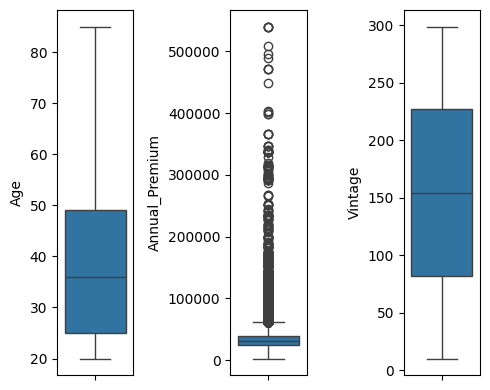

In [275]:
nums = ["Age","Annual_Premium","Vintage"]

plt.figure(figsize=(5, 4))
for i in range(0, len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.boxplot(y=train[nums[i]], orient='v')
    plt.tight_layout()

Setelah dilakukan pengecekan outlier pada kolom numerikal dengan menggunakan boxplot didapat bahwa kolom 'Age' dan 'Vintage' tidak memiliki outlier, sedangakan pada kolom 'Annual_Premium' terdapat outliers.

In [276]:
def remove_outliers_iqr(dataframe, column_name):
    # Calculate the IQR
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to exclude outliers
    filtered_dataframe = dataframe[(dataframe[column_name] >= lower_bound) & (dataframe[column_name] <= upper_bound)]

    # Display information about the removed outliers
    outliers_removed = dataframe.shape[0] - filtered_dataframe.shape[0]
    print(f"Number of outliers removed in '{column_name}': {outliers_removed}")

    return filtered_dataframe

Karena visualisasi outlier dilakukan menggunakan boxplot, maka penghapusan outlier akan menggunakan metode IQR 

Number of outliers removed in 'Annual_Premium': 10320


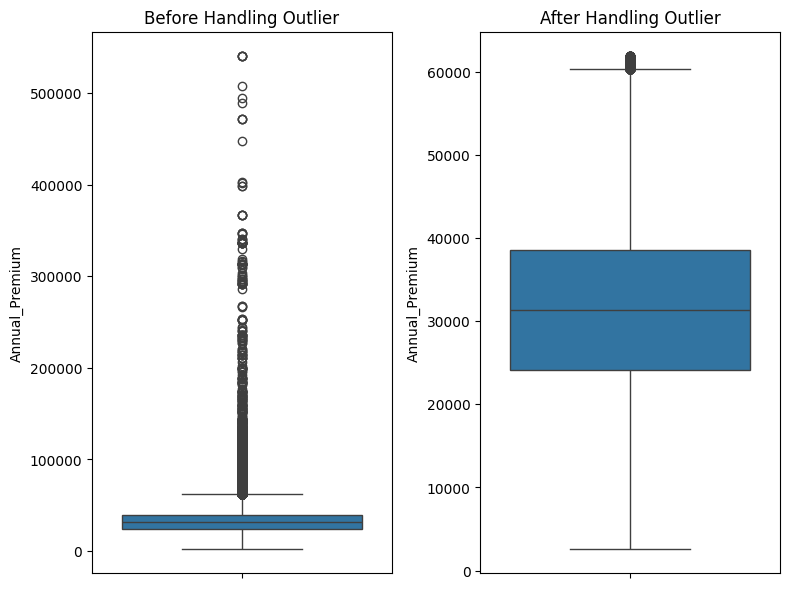

In [277]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.boxplot(train['Annual_Premium'], ax=axes[0])
axes[0].set_title('Before Handling Outlier')

# Using IQR to handle outlier
train = remove_outliers_iqr(train, 'Annual_Premium')

sns.boxplot(train['Annual_Premium'], ax=axes[1])
axes[1].set_title('After Handling Outlier')

plt.tight_layout()
plt.show()

Dapat dilihat outlier sudah terhapus sebanyak 1320, dapat dilihat pada boxplot bahwa range dari data annual premium sudah masuk ke dalam range boxplot yang lama

### Feature Transformation

In [278]:
nums = ['Age', 'Annual_Premium', 'Vintage']

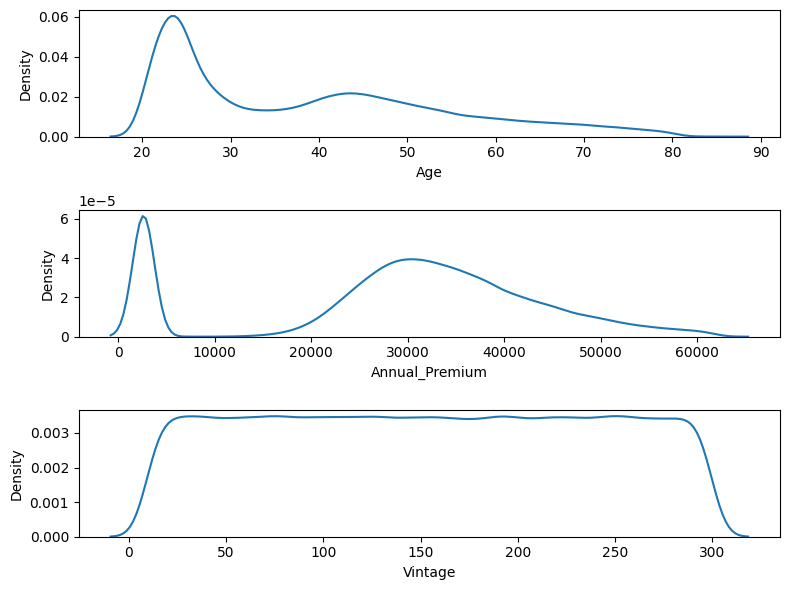

In [279]:
plt.figure(figsize=(8, 6))
for i in range(0, len(nums)):
    plt.subplot(len(nums), 1, i+1)
    sns.kdeplot(train[nums[i]])
    plt.tight_layout()

Dapat dilihat bahwa persebaran fitur numerik pada daset ini belum normal. Selanjutnya, pada annual_premium dapat dilihat bahwa range yang dimiliki sangat berbeda jauh dari kedua fitur numerik lainnya. Maka dari itu, Transformasi fitur akan menggunakan Log Tranformation untuk membuat distribusi fitur lebih simetrik.

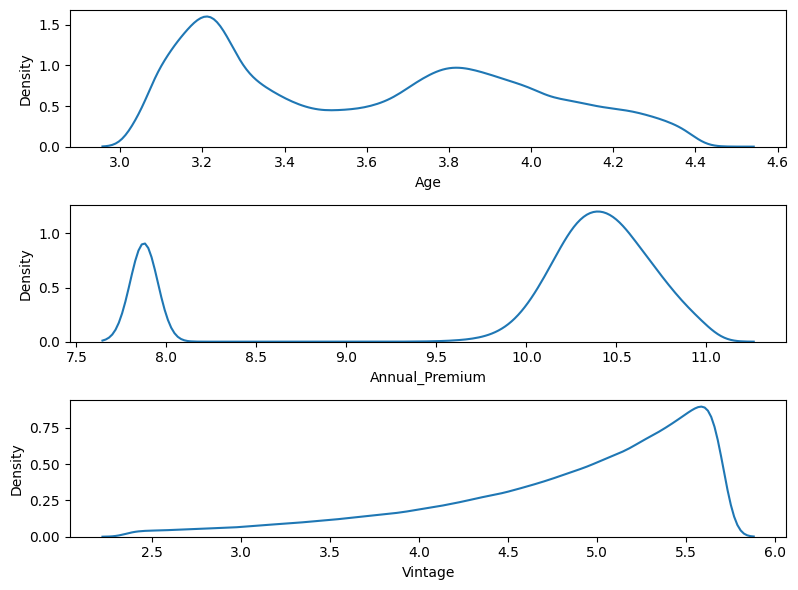

In [280]:
plt.figure(figsize=(8, 6))
for i in range(0, len(nums)):
    # Do Log Transformation
    train[nums[i]] = np.log1p(train[nums[i]])
    test[nums[i]] = np.log1p(train[nums[i]])

    # Plot the result
    plt.subplot(len(nums), 1, i+1)
    sns.kdeplot(train[nums[i]])
    plt.tight_layout()

### Feature Encodinng

Feature encoding akan dilakukan terhadap variable kategorikal supaya menjadi variable numerik dengan label encoding

In [281]:
cats = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [282]:
train[cats].describe()

Gender Vehicle_Age Vehicle_Damage
count   370789      370789         370789
unique       2           3              2
top       Male    1-2 Year            Yes
freq    200319      194212         186561

Di bawah ini adalah label encoding untuk fitur kategorikal yang ada 

In [283]:
mapping_gender = {
     'Male' : 0,
     'Female' : 1
}

mapping_vehicle_age = {
     '< 1 Year' : 0,
     '1-2 Year' : 1,
     '> 2 Years' : 2
}

mapping_vehicle_damage = {
     'No' : 0,
     'Yes' : 1
}

Label encoding akan dilakukan pada train dan test agar fitur yang dimasukkan ke dalam model machine learning dapat direpresentasikan sebagai nilai numerik. 

In [284]:
train['Gender'] = train['Gender'].map(mapping_gender)
test['Gender'] = test['Gender'].map(mapping_gender)

In [285]:
train['Vehicle_Age'] = train['Vehicle_Age'].map(mapping_vehicle_age)
test['Vehicle_Age'] = test['Vehicle_Age'].map(mapping_vehicle_age)

In [286]:
train['Vehicle_Damage'] = train['Vehicle_Damage'].map(mapping_vehicle_damage)
test['Vehicle_Damage'] = test['Vehicle_Damage'].map(mapping_vehicle_damage)

### Handle Class Imbalance

In [287]:
train.Response.value_counts()

Response
0    325634
1     45155
Name: count, dtype: int64

Dapat dilihat, hasil response menunjukkan bahwa terjadi class imbalance antara response 0 dan 1.

In [288]:
X_train = train.drop('Response', axis=1)
y_train = train['Response']

Pada penelitian ini, kami akan menggunakan undersampling karena ingin menangani ketidakseimbangan kelas dalam dataset. Undersampling membantu mengurangi jumlah instansi dari kelas mayoritas sehingga setiap kelas memiliki jumlah observasi yang lebih seimbang. 

Kami melakukan undersampling karena banyak data kelas minoritas masih cukup banyak dan kami beropini bahwa menggunakan data real lebih baik daripada membuat data sintetis menggunakan oversampling

In [289]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [290]:
train = pd.concat([X_train, y_train], axis=1)
train.Response.value_counts()

Response
0    45155
1    45155
Name: count, dtype: int64

Dapat dilihat, sekarang class response menjadi seimbang

In [291]:
train.head()

Gender       Age  Driving_License  Region_Code  Previously_Insured  \
255531       1  3.091042                1         46.0                   1   
27423        1  3.258097                1         46.0                   1   
253915       0  3.970292                1         46.0                   1   
167018       1  3.367296                1         18.0                   1   
26965        1  3.806662                1         11.0                   0   

        Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
255531            0               0       10.325384                 152.0   
27423             0               0       10.485871                 152.0   
253915            1               1       10.198468                  26.0   
167018            0               0       10.979087                 152.0   
26965             1               1       10.411810                 122.0   

         Vintage  Response  
255531  5.049856         0  
27423   5.602119         0  
253915  4.663439         0  
167018  3.332205         0  
26965   5.313206         0

## Feature Engineering

### Feature Extraction

Feature extraction akan dilakukan dengan membuat feature baru dari feature yang sudah ada. Feature extraction ini akan dilakukan pada data train dan test agar kedua data tersebut memiliki dimensi yang sama ketika dimasukkan ke dalam model.

#### Vintage Bin

In [292]:
train['Vintage'].describe()

count    90310.000000
mean         4.819421
std          0.763741
min          2.397895
25%          4.406719
50%          5.036953
75%          5.424950
max          5.703782
Name: Vintage, dtype: float64

In [293]:
q1 = train['Vintage'].quantile(0.25)
q2 = train['Vintage'].quantile(0.5)
q3 = train['Vintage'].quantile(0.75)

In [294]:
def label_encoding(vintage):
    if vintage <= q1:
        return 0
    elif vintage <= q2:
        return 1
    else:
        return 2

In [295]:
train['Vintage_Binned'] = train['Vintage'].apply(label_encoding)
test['Vintage_Binned'] = test['Vintage'].apply(label_encoding)

#### Age Bin

In [296]:
train['Age'].describe()

count    90310.000000
mean         3.669481
std          0.349566
min          3.044522
25%          3.332205
50%          3.713572
75%          3.931826
max          4.430817
Name: Age, dtype: float64

In [297]:
q1 = train['Age'].quantile(0.25)
q2 = train['Age'].quantile(0.5)
q3 = train['Age'].quantile(0.75)

In [298]:
def label_encoding(age):
    if age <= q1:
        return 0
    elif age <= q2:
        return 1
    else:
        return 2

In [299]:
train['Age_Bin'] = train['Age'].apply(label_encoding)
test['Age_Bin'] = test['Age'].apply(label_encoding)

#### Premium to Age Ratio

In [300]:
train['Premium_to_Age_Ratio'] = train['Annual_Premium'] / train['Age']

In [301]:
test['Premium_to_Age_Ratio'] = test['Annual_Premium'] / test['Age']

#### Age and Vehicle Age

In [302]:
train['Age_Vehicle_Age_Interaction'] = train['Age_Bin'] * train['Vehicle_Age']

In [303]:
test['Age_Vehicle_Age_Interaction'] = test['Age_Bin'] * test['Vehicle_Age']

#### Vehicle Damage dan Age

In [304]:
train['Vehicle_Damage_Age_Interaction'] = train['Age_Bin'] * train['Vehicle_Damage']

In [305]:
test['Vehicle_Damage_Age_Interaction'] = test['Age_Bin'] * test['Vehicle_Damage']

#### Save Result

In [308]:
train['Response'] = train.pop('Response')
train.head()

Gender       Age  Driving_License  Region_Code  Previously_Insured  \
255531       1  3.091042                1         46.0                   1   
27423        1  3.258097                1         46.0                   1   
253915       0  3.970292                1         46.0                   1   
167018       1  3.367296                1         18.0                   1   
26965        1  3.806662                1         11.0                   0   

        Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
255531            0               0       10.325384                 152.0   
27423             0               0       10.485871                 152.0   
253915            1               1       10.198468                  26.0   
167018            0               0       10.979087                 152.0   
26965             1               1       10.411810                 122.0   

         Vintage  Vintage_Binned  Age_Bin  Premium_to_Age_Ratio  \
255531  5.049856               2        0              3.340421   
27423   5.602119               2        0              3.218404   
253915  4.663439               1        2              2.568695   
167018  3.332205               0        1              3.260506   
26965   5.313206               2        2              2.735155   

        Age_Vehicle_Age_Interaction  Vehicle_Damage_Age_Interaction  Response  
255531                            0                               0         0  
27423                             0                               0         0  
253915                            2                               2         0  
167018                            0                               0         0  
26965                             2                               2         0

In [307]:
test.head()

Gender       Age  Driving_License  Region_Code  Previously_Insured  \
0       0  1.570003                1         11.0                   1   
1       0  1.675938                1         28.0                   0   
2       0  1.583341                1         28.0                   0   
3       0  1.408800                1         27.0                   1   
4       0  1.481877                1         28.0                   1   

   Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
0            0               0        2.451690                 152.0   
1            1               1        2.435402                   7.0   
2            1               1        2.446952                 124.0   
3            0               1        2.421422                 152.0   
4            0               0        2.417861                 152.0   

    Vintage  Vintage_Binned  Age_Bin  Premium_to_Age_Ratio  \
0  1.853872               0        0              1.561583   
1  1.826955               0        0              1.453157   
2  1.466077               0        0              1.545436   
3  1.843422               0        0              1.718784   
4  1.545194               0        0              1.631621   

   Age_Vehicle_Age_Interaction  Vehicle_Damage_Age_Interaction  
0                            0                               0  
1                            0                               0  
2                            0                               0  
3                            0                               0  
4                            0                               0

In [309]:
train.to_csv('../../dataset/after_extraction/train.csv')
test.to_csv('../../dataset/after_extraction/test.csv')

In [4]:
train = pd.read_csv('../../dataset/after_extraction/train.csv')
train.head()

Unnamed: 0  Gender       Age  Driving_License  Region_Code  \
0      255531       1  3.091042                1         46.0   
1       27423       1  3.258097                1         46.0   
2      253915       0  3.970292                1         46.0   
3      167018       1  3.367296                1         18.0   
4       26965       1  3.806662                1         11.0   

   Previously_Insured  Vehicle_Age  Vehicle_Damage  Annual_Premium  \
0                   1            0               0       10.325384   
1                   1            0               0       10.485871   
2                   1            1               1       10.198468   
3                   1            0               0       10.979087   
4                   0            1               1       10.411810   

   Policy_Sales_Channel   Vintage  Vintage_Binned  Age_Bin  \
0                 152.0  5.049856               2        0   
1                 152.0  5.602119               2        0   
2                  26.0  4.663439               1        2   
3                 152.0  3.332205               0        1   
4                 122.0  5.313206               2        2   

   Premium_to_Age_Ratio  Age_Vehicle_Age_Interaction  \
0              3.340421                            0   
1              3.218404                            0   
2              2.568695                            2   
3              3.260506                            0   
4              2.735155                            2   

   Vehicle_Damage_Age_Interaction  Response  
0                               0         0  
1                               0         0  
2                               2         0  
3                               0         0  
4                               2         0

### Feature Selection

<Axes: >

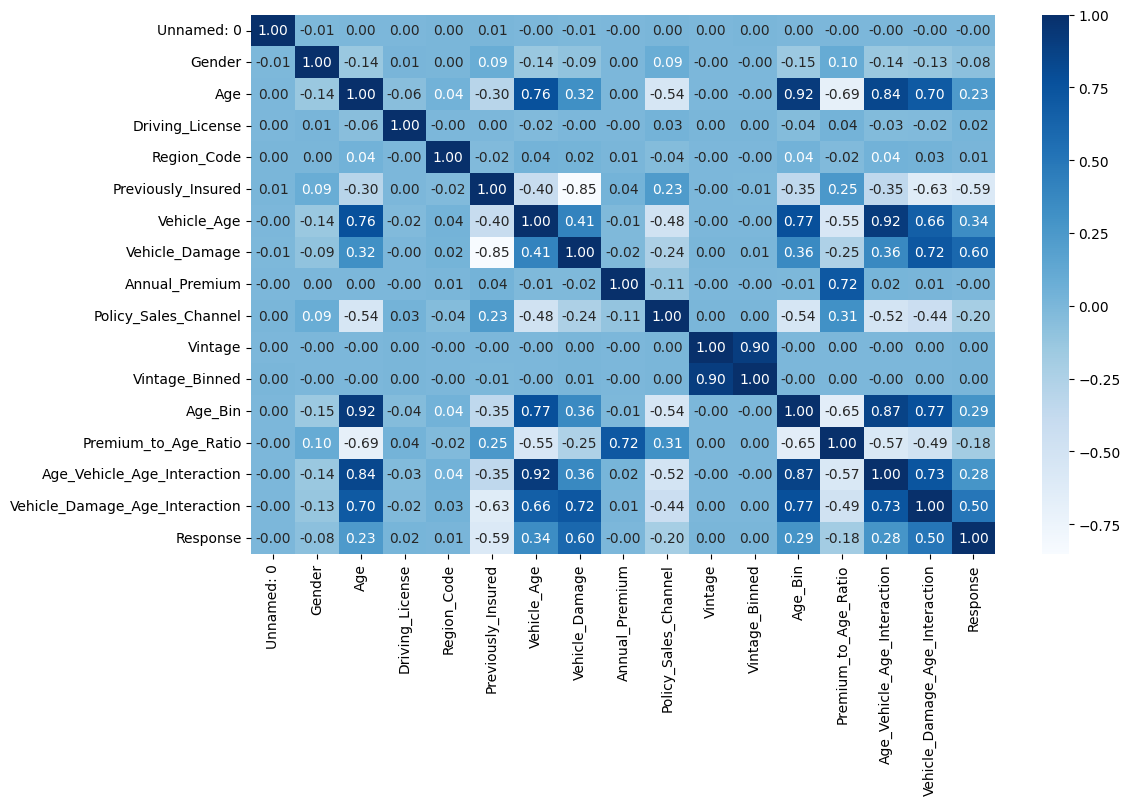

In [38]:
plt.figure(figsize=(12, 7))
sns.heatmap(train.corr(), cmap='Blues', annot=True, fmt='.2f')

### 2. feature selection berdasarkan korelasi antara feature yang bernilai redundant/ > 0.85
    
   * Age dengan Age Bin (Age Di hapus)

      Age dengan Age Bin,  bernilai Redundant yaitu 0,92 maka salah satu tersebut harus dihapus dengan pertimbangan diantara kedua feature tersebut mana yang memiliki korelasi paling tinggi terhadap Response

        Age terhadap target/ Response = 0.11
        Age Bin terhadap target/ Response = 0.29
      
      Maka yang di hapus adalah feature Age

  * Vehicle Age dengan Age vehicle Age Interaction (Age vehicle Age Interaction di hapus)

      Vehicle Age dengan Age vehicle Age Interaction bernilai Redundant yaitu 0,92 maka salah satu tersebut harus dihapus dengan pertimbangan diantara kedua feature tersebut mana yang memiliki korelasi paling tinggi terhadap Response
     
        Vehicle Age terhadap target/ Response = 0.34
        Age vehicle Age Interactionterhadap target/ Response = 0.28
    
    Maka Age vehicle Age Interaction di hapus dari data set

  * Vintage dengan Vintage Binned (vintage Binned)

      Vintage dengan Vintage Binbernilai Redundant yaitu 0,90 maka salah satu tersebut harus dihapus dengan pertimbangan diantara kedua feature tersebut mana yang memiliki korelasi paling tinggi terhadap Response
    
        Vintage terhadap target/ Response = 0.00
        Vintage Binned hadap target/ Response = 0.00
    
    Karena kedua nilai tersebut sama, maka salah satunya harus tetap di hapus yaitu Vintage Binned
      
  * Previously_Insured dengan Vehicle_Damage benilai Redundant yaitu -0.82, akan tetapi di pertahankan    dengan pertimbangan :
    
      kedua feature bernilai Redundant yaitu -0.82 akan tetapi jika berasumsi terhadap kolom tersebut penting dalam menentukan response 0 atau 1 , kalau dilihat dari distribusinya Previously_Insured (customer sudah memiliki asuransi kendaraan atau belum) banyak berpengaruh pada response 1, begitu juga dengan Vehicle_Damage (customer pernah mengalami kerusakan kendaraan atau belum) terhadap response bernilai 1  distribusinya pada data set cukup banyak, bisa jadi karena pernah mengalami kerusakan kendaraan jadi customer tertarik untuk berlangganan asuransi kendaraan.

  *  Annual_Premium dengan Premium to Age Ratio (Annual Premium di hapus dari data set)
    
       Premium_to_Age_Ratio dengan Annual_Premium bernilai redundant yaitu 0.76, maka salah satunya harus di hapus dengan pertimbangan diantara kedua feature tersebut mana yang memiliki korelasi paling tinggi terhadap target

       Premium_to_Age_Ratio terhadap target/ Response = 0.02
       Annual_Premium terhadap target/ Response = -0.08

       Maka Annual Premium di hapus dari data set.


### 1. Feature Selection berdasarkan pengujian untuk setiap Feature menggunakan Metode Mutual Information dan Chi-Square

In [53]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency
# Membaca DataFrame dari file CSV
train = pd.read_csv('../../dataset/after_extraction/train.csv')
test = pd.read_csv('../../dataset/after_extraction/test.csv')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90310 entries, 0 to 90309
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      90310 non-null  int64  
 1   Gender                          90310 non-null  int64  
 2   Age                             90310 non-null  float64
 3   Driving_License                 90310 non-null  int64  
 4   Region_Code                     90310 non-null  float64
 5   Previously_Insured              90310 non-null  int64  
 6   Vehicle_Age                     90310 non-null  int64  
 7   Vehicle_Damage                  90310 non-null  int64  
 8   Annual_Premium                  90310 non-null  float64
 9   Policy_Sales_Channel            90310 non-null  float64
 10  Vintage                         90310 non-null  float64
 11  Vintage_Binned                  90310 non-null  int64  
 12  Age_Bin                         

In [42]:
# Menghilangkan kolom yang Ddi hapus berdasarkan Metode feature yang mengalami Redundan/ bernilai lebih dari 0.85
kolom_yang_dihapus = ['Response','Age','Age_Vehicle_Age_Interaction','Vintage_Binned','Annual_Premium']
features = train.drop(kolom_yang_dihapus, axis=1)

features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90310 entries, 0 to 90309
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      90310 non-null  int64  
 1   Gender                          90310 non-null  int64  
 2   Driving_License                 90310 non-null  int64  
 3   Region_Code                     90310 non-null  float64
 4   Previously_Insured              90310 non-null  int64  
 5   Vehicle_Age                     90310 non-null  int64  
 6   Vehicle_Damage                  90310 non-null  int64  
 7   Policy_Sales_Channel            90310 non-null  float64
 8   Vintage                         90310 non-null  float64
 9   Age_Bin                         90310 non-null  int64  
 10  Premium_to_Age_Ratio            90310 non-null  float64
 11  Vehicle_Damage_Age_Interaction  90310 non-null  int64  
dtypes: float64(4), int64(8)
memory u

In [43]:
features.head()

Unnamed: 0  Gender  Driving_License  Region_Code  Previously_Insured  \
0      255531       1                1         46.0                   1   
1       27423       1                1         46.0                   1   
2      253915       0                1         46.0                   1   
3      167018       1                1         18.0                   1   
4       26965       1                1         11.0                   0   

   Vehicle_Age  Vehicle_Damage  Policy_Sales_Channel   Vintage  Age_Bin  \
0            0               0                 152.0  5.049856        0   
1            0               0                 152.0  5.602119        0   
2            1               1                  26.0  4.663439        2   
3            0               0                 152.0  3.332205        1   
4            1               1                 122.0  5.313206        2   

   Premium_to_Age_Ratio  Vehicle_Damage_Age_Interaction  
0              3.340421                               0  
1              3.218404                               0  
2              2.568695                               2  
3              3.260506                               0  
4              2.735155                               2

#### Dilakukan Label Encoding untuk pengujian Mutual information dan Chi-Square karena feature harus bertipe kategorikal

In [44]:

from sklearn.preprocessing import LabelEncoder
for col in features.columns:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col])
features.head()

Unnamed: 0  Gender  Driving_License  Region_Code  Previously_Insured  \
0       60587       1                1           46                   1   
1        6501       1                1           46                   1   
2       60213       0                1           46                   1   
3       39508       1                1           18                   1   
4        6406       1                1           11                   0   

   Vehicle_Age  Vehicle_Damage  Policy_Sales_Channel  Vintage  Age_Bin  \
0            0               0                   126      145        0   
1            0               0                   126      260        0   
2            1               1                    23       95        2   
3            0               0                   126       17        1   
4            1               1                   102      192        2   

   Premium_to_Age_Ratio  Vehicle_Damage_Age_Interaction  
0                 67718                               0  
1                 60190                               0  
2                  9178                               2  
3                 63036                               0  
4                 26460                               2

### pengujian Mutual information dapat dilakukan dengan menggunakan tipe data kategorikal ataupun numerikal
 
 Dengan Pertimbangan nilai Mutal Information
 
* Mutal Information < 0.02: tidak bisa digunakan untuk prediksi
* 0.02 ≤ Mutal Information < 0.1: weak predictor
* 0.1 ≤ Mutal Information < 0.3: moderate predictor
* 0.3 ≤ Mutal Information < 0.5: strong predictor
* Mutal Information ≥ 0.5: suspicious predictor

In [48]:

# Mutual Information dengan feature encoding

mutual_info_values = mutual_info_classif(features, train['Response'])
print("\nMutual Information:")
for column, mi in zip(features.columns, mutual_info_values):
    print(f"{column}: {mi}")




Mutual Information:
Unnamed: 0: 0.0
Gender: 0.009850142892536384
Driving_License: 0.00888954380142426
Region_Code: 0.02342921450209956
Previously_Insured: 0.22469129243372254
Vehicle_Age: 0.0682555100059814
Vehicle_Damage: 0.21959586490041993
Policy_Sales_Channel: 0.10064080852039092
Vintage: 0.0
Age_Bin: 0.0670335023289077
Premium_to_Age_Ratio: 0.06730438969765062
Vehicle_Damage_Age_Interaction: 0.17833157319911885


In [46]:
# Mutual Information dengan data set tidak dilakukan encoding

mutual_info_values = mutual_info_regression(train, train['Response'])
print("\nMutual Information:")
for column, mi in zip(features.columns, mutual_info_values):
    print(f"{column}: {mi}")




Mutual Information:
Unnamed: 0: 0.0
Gender: 0.003123553119994682
Driving_License: 0.06975209749103684
Region_Code: 0.0
Previously_Insured: 0.026838975259560804
Vehicle_Age: 0.22319677938428217
Vehicle_Damage: 0.06264364544182577
Policy_Sales_Channel: 0.21121699020381346
Vintage: 0.0046138914641638
Age_Bin: 0.09602409525249112
Premium_to_Age_Ratio: 0.002209415337581788
Vehicle_Damage_Age_Interaction: 0.0026198310921099477


### Penjelasan Feature Selection berdasarkan pengujian untuk setiap Feature menggunakan Metode Mutual Information dan Chi-Square

###  Mutual Information 

Mutual information menggunakan data set yang dilakukan label encoding (Kategorikal) dengan Mutual   information menggunakan data set yang tidak dilakukan label encoding (numerikal) memiliki nilai mutual_info_values yang tidak jauh berbeda.


Mutual Information tidak dilakukan label endoding:
* Gender: 0.003123553119994682
* Driving_License: 0.06975209749103684
* Region_Code: 0.0
* Previously_Insured: 0.026838975259560804
* Vehicle_Age: 0.22319677938428217
* Vehicle_Damage: 0.06264364544182577
* Policy_Sales_Channel: 0.21121699020381346
* Vintage: 0.0046138914641638
* Age_Bin: 0.09602409525249112
* Premium_to_Age_Ratio: 0.002209415337581788
* Vehicle_Damage_Age_Interaction: 0.0026198310921099477


Mutual Information dilakukan label endoding:
* Gender: 0.009850142892536384
* Driving_License: 0.00888954380142426
* Region_Code: 0.02342921450209956
* Previously_Insured: 0.22469129243372254
* Vehicle_Age: 0.0682555100059814
* Vehicle_Damage: 0.21959586490041993
* Policy_Sales_Channel: 0.10064080852039092
* Vintage: 0.0
* Age_Bin: 0.0670335023289077
* Premium_to_Age_Ratio: 0.06730438969765062
* Vehicle_Damage_Age_Interaction: 0.17833157319911885


Dapat dilihat dari nilai mutual_info_values dari kedua pengujian tersebut bahwa :
*  feature Vintage memiliki nilai < dari 0.02 di kedua pengujian, yang berarti feature tersebut tidak bisa digunakan untuk prediksi.
*  Feature Premium_to_Age_Ratio memiliki nilai < 0.02 di kedua pengujian, yang berarti feature tersebut tidak bisa digunakan untuk prediksi.
*  Feature Gender memiliki nilai < dari 0.02 di kedua pengujian, yang berarti feature tersebut tidak bisa digunakan untuk prediksi.

# Kesimpulan 

* Feature Vintage, Premium To Age Ratio, dan Gender harus di hapus dari data set berdasarkan pertimbangan dari hasil pengujian menggunakan metode Mutual Information


In [54]:
train.head()

Unnamed: 0  Gender       Age  Driving_License  Region_Code  \
0      255531       1  3.091042                1         46.0   
1       27423       1  3.258097                1         46.0   
2      253915       0  3.970292                1         46.0   
3      167018       1  3.367296                1         18.0   
4       26965       1  3.806662                1         11.0   

   Previously_Insured  Vehicle_Age  Vehicle_Damage  Annual_Premium  \
0                   1            0               0       10.325384   
1                   1            0               0       10.485871   
2                   1            1               1       10.198468   
3                   1            0               0       10.979087   
4                   0            1               1       10.411810   

   Policy_Sales_Channel   Vintage  Vintage_Binned  Age_Bin  \
0                 152.0  5.049856               2        0   
1                 152.0  5.602119               2        0   
2                  26.0  4.663439               1        2   
3                 152.0  3.332205               0        1   
4                 122.0  5.313206               2        2   

   Premium_to_Age_Ratio  Age_Vehicle_Age_Interaction  \
0              3.340421                            0   
1              3.218404                            0   
2              2.568695                            2   
3              3.260506                            0   
4              2.735155                            2   

   Vehicle_Damage_Age_Interaction  Response  
0                               0         0  
1                               0         0  
2                               2         0  
3                               0         0  
4                               2         0

In [57]:

kolom_yang_dihapus = ['Response','Age','Age_Vehicle_Age_Interaction','Vintage_Binned','Annual_Premium','Vintage','Premium_to_Age_Ratio','Gender']
# Menghilangkan kolom yang tidak dibutuhkan
train_after_selection = train.drop(kolom_yang_dihapus, axis=1)
test_after_selection= test.drop(kolom_yang_dihapus, axis=1)

train_after_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90310 entries, 0 to 90309
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      90310 non-null  int64  
 1   Driving_License                 90310 non-null  int64  
 2   Region_Code                     90310 non-null  float64
 3   Previously_Insured              90310 non-null  int64  
 4   Vehicle_Age                     90310 non-null  int64  
 5   Vehicle_Damage                  90310 non-null  int64  
 6   Policy_Sales_Channel            90310 non-null  float64
 7   Age_Bin                         90310 non-null  int64  
 8   Vehicle_Damage_Age_Interaction  90310 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 6.2 MB


In [58]:
test_after_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90310 entries, 0 to 90309
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      90310 non-null  int64  
 1   Driving_License                 90310 non-null  int64  
 2   Region_Code                     90310 non-null  float64
 3   Previously_Insured              90310 non-null  int64  
 4   Vehicle_Age                     90310 non-null  int64  
 5   Vehicle_Damage                  90310 non-null  int64  
 6   Policy_Sales_Channel            90310 non-null  float64
 7   Age_Bin                         90310 non-null  int64  
 8   Vehicle_Damage_Age_Interaction  90310 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 6.2 MB


In [61]:
train_after_selection.to_csv('../../dataset/after_selection/train_after_selection.csv')
test_after_selection.to_csv('../../dataset/after_selection/test_after_selection.csv')

### Feature Tambahan

1. **Feature Income** 

    diperlukan untuk melihat penghasilan pelanggan yang dapat membantu mengidentifikasi kategori pelanggan yang lebih cocok untuk ditawarkan produk baru, seperti Asuransi Kendaraan Bermotor. Feature ini bertipe numerical

2. **Feature Retirement_Savings** 

    diperlukan untuk melihat Pelanggan yang sudah menyimpan uang untuk pensiun dapat dianggap sebagai kandidat yang tepat untuk menawarkan produk asuransi. Feature ini bertipe boolean

3. **Feature Vehicle** 

    adalah feature yang berisi berapa banyak pelanggan memiliki kendaraan. Kendaraan yang dimiliki pelanggan dapat memberikan gambaran tentang budget mereka untuk pembelian asuransi. Feature ini bertipe numerical

4. **Feature Home_Ownership** 

    adalah feature yang berisi apakah pelanggan memiliki rumah pribadi atau tidak. Status kepemilikan rumah pelanggan dapat memberikan gambaran tentang status keuangan mereka. Misalnya, pemilik rumah dapat dianggap lebih stabil finansial untuk mengambil alat asuransi yang mengandalkan pemilik rumah. Feature ini bertipe boolean

5. **Feature Employment_Status** 

    adalah feature yang berisi tentang status pekerjaan yang dimiliki nasabah, seperti contohnya Full-time, Intern, dll. Status pekerjaan pelanggan dapat memberikan informasi tambahan tentang preferensi mereka saat memilih asuransi. Feature bertipe Object